# 1.2 ニューラルネットワークの推論

In [1]:
import numpy as np

In [2]:
class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [3]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        return out

In [4]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]

        # すべての重みをリストにまとめる
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [5]:
TwoLayerNet(2, 4, 3).predict(np.random.randn(10, 2))

array([[-1.79156168e-01,  1.04604197e+00, -6.09385024e-01],
       [-1.27742276e-01,  1.10183796e+00, -5.82613172e-01],
       [-4.15038497e-01,  8.05477215e-01, -1.00476909e+00],
       [-4.36363052e-01,  1.51165801e+00, -5.39209561e-02],
       [-2.70618156e-01,  1.00893632e+00, -4.26712961e-01],
       [-3.28000881e-01,  1.73260157e+00, -1.31893860e-01],
       [-5.76487815e-01,  6.50542529e-01, -9.55325072e-01],
       [-3.49887242e-01,  1.82813358e+00, -1.46523260e-01],
       [-1.20184916e+00,  2.64929654e+00, -2.81866473e-01],
       [-5.92867696e-01,  1.58268516e+00, -2.52304203e-03]])

# 1.3 ニューラルネットワークの学習

In [6]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [7]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [8]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [11]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

# 1.4 ニューラルネットワークで問題を解く

In [12]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # クラスごとのサンプル数
    DIM = 2  # データの要素数
    CLS_NUM = 3  # クラス数

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N):#N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [13]:
x, t = load_data()

In [14]:
'x', x.shape

('x', (300, 2))

In [15]:
't', t.shape

('t', (300, 3))

In [16]:
import matplotlib.pyplot as plt

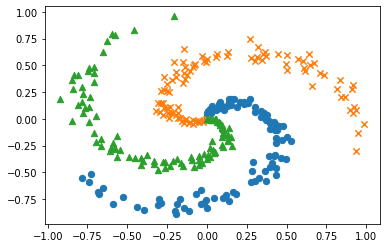

In [17]:
# データ点のプロット
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [18]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [19]:
# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # データのシャッフル
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 定期的に学習経過を出力
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch %d |  iter %d / %d | loss %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| epoch 1 |  iter 10 / 10 | loss 1.13
| epoch 2 |  iter 10 / 10 | loss 1.13
| epoch 3 |  iter 10 / 10 | loss 1.12
| epoch 4 |  iter 10 / 10 | loss 1.12
| epoch 5 |  iter 10 / 10 | loss 1.11
| epoch 6 |  iter 10 / 10 | loss 1.14
| epoch 7 |  iter 10 / 10 | loss 1.16
| epoch 8 |  iter 10 / 10 | loss 1.11
| epoch 9 |  iter 10 / 10 | loss 1.12
| epoch 10 |  iter 10 / 10 | loss 1.13
| epoch 11 |  iter 10 / 10 | loss 1.12
| epoch 12 |  iter 10 / 10 | loss 1.11
| epoch 13 |  iter 10 / 10 | loss 1.09
| epoch 14 |  iter 10 / 10 | loss 1.08
| epoch 15 |  iter 10 / 10 | loss 1.04
| epoch 16 |  iter 10 / 10 | loss 1.03
| epoch 17 |  iter 10 / 10 | loss 0.96
| epoch 18 |  iter 10 / 10 | loss 0.92
| epoch 19 |  iter 10 / 10 | loss 0.92
| epoch 20 |  iter 10 / 10 | loss 0.87
| epoch 21 |  iter 10 / 10 | loss 0.85
| epoch 22 |  iter 10 / 10 | loss 0.82
| epoch 23 |  iter 10 / 10 | loss 0.79
| epoch 24 |  iter 10 / 10 | loss 0.78
| epoch 25 |  iter 10 / 10 | loss 0.82
| epoch 26 |  iter 10 / 10 | loss 

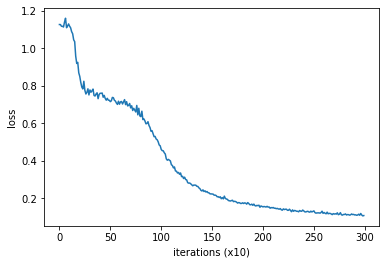

In [20]:
# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

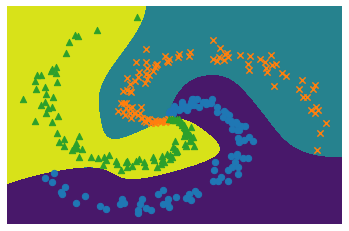

In [21]:
# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [22]:
import time

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [23]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [24]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [25]:
trainer = Trainer(TwoLayerNet(input_size=2, hidden_size=10, output_size=3), SGD(lr=1.0))
trainer.fit(x, t, 300, 30, eval_interval=10)

| epoch 1 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 2 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 3 |  iter 1 / 10 | time 0[s] | loss 1.13
| epoch 4 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 6 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 7 |  iter 1 / 10 | time 0[s] | loss 1.14
| epoch 8 |  iter 1 / 10 | time 0[s] | loss 1.16
| epoch 9 |  iter 1 / 10 | time 0[s] | loss 1.11
| epoch 10 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 11 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 13 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 14 |  iter 1 / 10 | time 0[s] | loss 1.09
| epoch 15 |  iter 1 / 10 | time 0[s] | loss 1.08
| epoch 16 |  iter 1 / 10 | time 0[s] | loss 1.04
| epoch 17 |  iter 1 / 10 | time 0[s] | loss 1.03
| epoch 18 |  iter 1 / 10 | time 0[s] | loss 0.94
| epoch 19 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 2

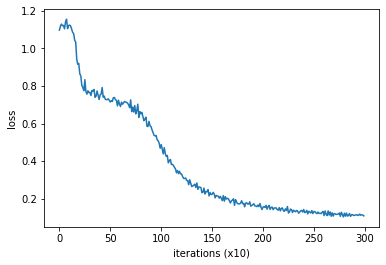

In [26]:
trainer.plot()